## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [116]:
# pandas and numpy
import pandas as pd
import numpy as numpy
import random
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [117]:
# load data 
# ----------
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
#congress_tweets = congress_tweets.sample(...)
#random.shuffle(congress_tweets)
# Shuffle the DataFrame rows
congress_tweets = congress_tweets.sample(frac=1, random_state=42)  # Using a random seed for reproducibility
# Subset to 8000 random tweets
congress_tweets = congress_tweets.head(8000)
congress_tweets.head()


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
908961,1.250810e+18,RepJayapal,2020-04-16T11:31:24-04:00,RT @RepKClark 22 million Americans filed for u...,Pramila Jayapal,Rep,3-Jan-17,9/21/1965,F,WA,7,Democrat,"1,221,747","1,742,718","1,755,396","1,290,670"
175615,1.098040e+18,RepJohnLarson,2019-02-19T20:51:22-05:00,Thanks to all who came out to tonight’s forum ...,John B. Larson,Rep,3-Jan-99,7/22/1948,M,CT,1,Democrat,"673,215","897,572","905,083","634,892"
64613,1.105510e+18,SpeakerPelosi,2019-03-12T12:55:01-04:00,RT @RepFilemonVela #Dreamers &amp; TPS recipie...,Nancy Pelosi,Rep,2-Jun-87,3/26/1940,F,CA,12,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
783091,1.174370e+18,JoaquinCastrotx,2019-09-18T13:24:49-04:00,RT @HispanicCaucus @JoaquinCastrotx @TheBlackC...,Joaquín Castro,Rep,3-Jan-13,9/16/1974,M,TX,20,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843"
553399,1.099380e+18,RepJoeMorelle,2019-02-23T13:29:08-05:00,Thank you to @NYGovCuomo for being here today ...,Joseph D. Morelle,Rep,13-Nov-18,4/29/1957,M,NY,25,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"


## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [119]:

def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub('', text)



def rem_punc_stop(text):
    stop_words = STOP_WORDS
    
    nlp.Defaults.stop_words |= {"RT","AMP","&","amp","QT"} ###removes the "RT" tag in addition to the normal set of stopwords.

    punc = set(punctuation)
    
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    # apply nlp to punctuation-free object
    doc = nlp(punc_free)
    
    # extract words from processed text 
    spacy_words = [token.text for token in doc]
    
    # filter out words 
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [120]:
# preprocessing and re-create "tokens" column
congress_tweets['text'] = congress_tweets['text'].map(lambda x: remove_urls(x)) # remove urls 
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x)) 


## Part 2: Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1: Word Counts By Party

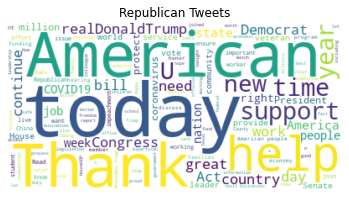

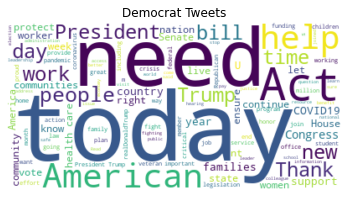

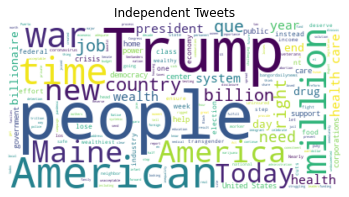

In [121]:
# Subset data to only include rows where the "name" field is "Nancy Pelosi and Ted Cruz"
rep_congress_tweets = congress_tweets[congress_tweets['party'].isin(['Republican'])]
dem_congress_tweets = congress_tweets[congress_tweets['party'].isin(['Democrat'])]
ind_congress_tweets = congress_tweets[congress_tweets['party'].isin(['Independent'])]



# apply function to text object
text = ' '.join(rep_congress_tweets['tokens'].map(lambda text: ' '.join(text)))

# create WordCloud visualization using the "text" object 
wordcloud = WordCloud(background_color = "white",  # set background color to white
                      random_state=41              # set random state to ensure same word cloud each time
                      ).generate(text)             # change the background color


# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.title("Republican Tweets")
plt.show()                             # show the plot

# apply function to text object
text = ' '.join(dem_congress_tweets['tokens'].map(lambda text: ' '.join(text)))

# create WordCloud visualization using the "text" object 
wordcloud = WordCloud(background_color = "white",  # set background color to white
                      random_state=41              # set random state to ensure same word cloud each time
                      ).generate(text)             # change the background color


# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.title("Democrat Tweets")
plt.show()                             # show the plot
# apply function to text object
text = ' '.join(ind_congress_tweets['tokens'].map(lambda text: ' '.join(text)))

# create WordCloud visualization using the "text" object 
wordcloud = WordCloud(background_color = "white",  # set background color to white
                      random_state=41              # set random state to ensure same word cloud each time
                      ).generate(text)             # change the background color


# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.title("Independent Tweets")
plt.show()                             # show the plot

### EDA 2: Document Length

In [131]:
# create new feature columns with counts of # of characters and # of words
# ----------

# count number of characters
congress_tweets['tweet_len'] = congress_tweets['tokens'].apply(len)

# count number of words
congress_tweets['word_count'] = congress_tweets['tokens'].apply(lambda x: len(str(x).split()))


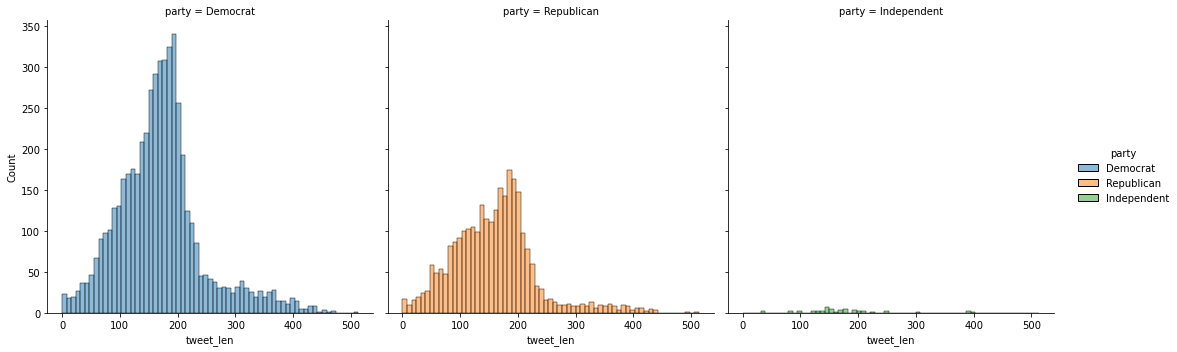

In [132]:
# create histogram of tweet length (number of characters)
sns.displot(congress_tweets,              # specify data
            x="tweet_len", #feature
           hue = "party",  # color by party 
            col = "party")  # color by party) 
plt.show()

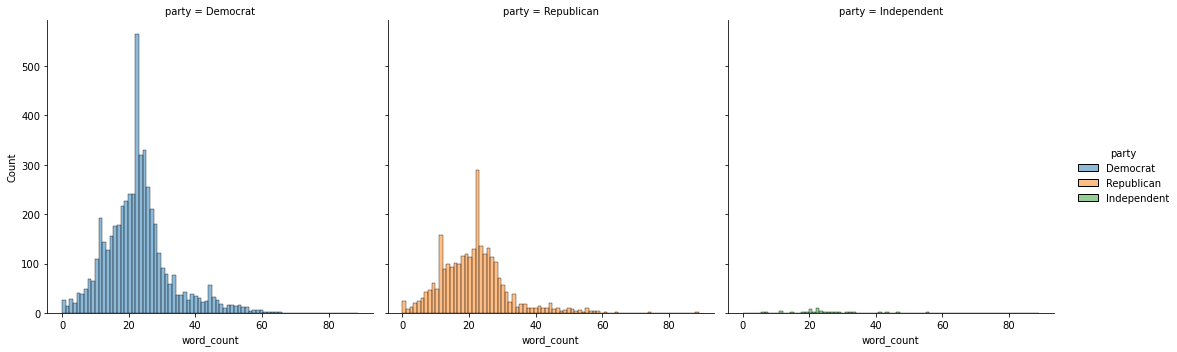

In [133]:
# create histogram of tweet length (number of characters)
sns.displot(congress_tweets,              # specify data
            x="word_count", #feature
           hue = "party",  # color by party 
            col = "party")  # color by party) 
plt.show()

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [126]:
# create a feature colum of sentiment polarity
# ---------- 
# create the "tokens" column again 
congress_tweets['tokens'] = congress_tweets['tokens'].map(lambda text: ' '.join(text))

# create the "tokens" column again 
congress_tweets['polarity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)


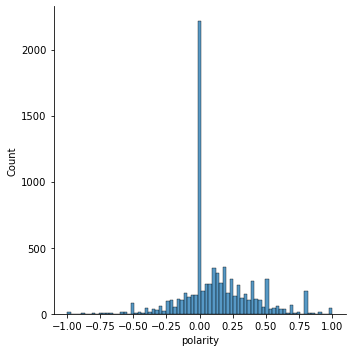

In [127]:
# histogram of combined polarity
sns.displot(congress_tweets,         # specify data
            x="polarity") # x-axis label 
plt.show()

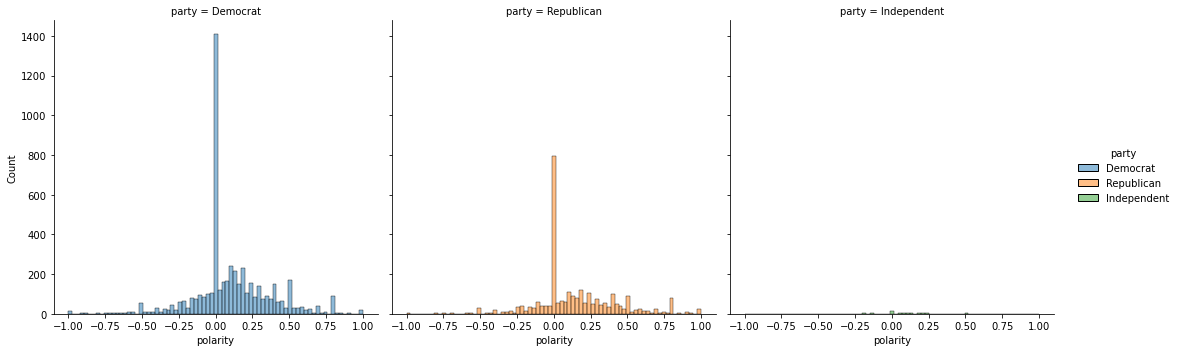

In [128]:
# histogram of word count by parties
sns.displot(congress_tweets,             # specify data
            x="polarity",   # x-axis feature
            hue = "party",  # color by party 
            col = "party")  # color by party 
plt.show()

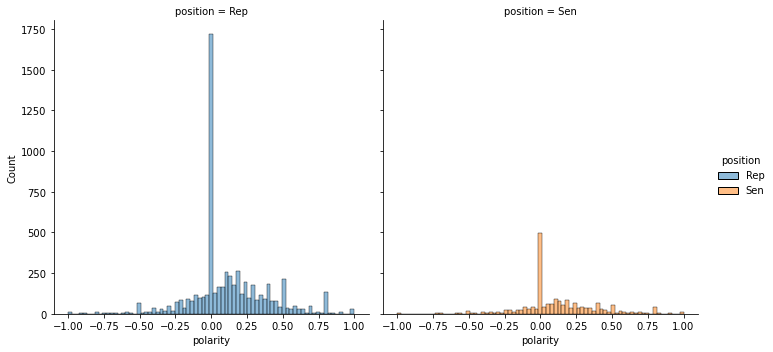

In [129]:
# histogram of word count by Rep vs Senator
sns.displot(congress_tweets,             # specify data
            x="polarity",   # x-axis feature
            hue = "position",  # color by rep/sen 
            col = "position")  # color by rep/sen 
plt.show()

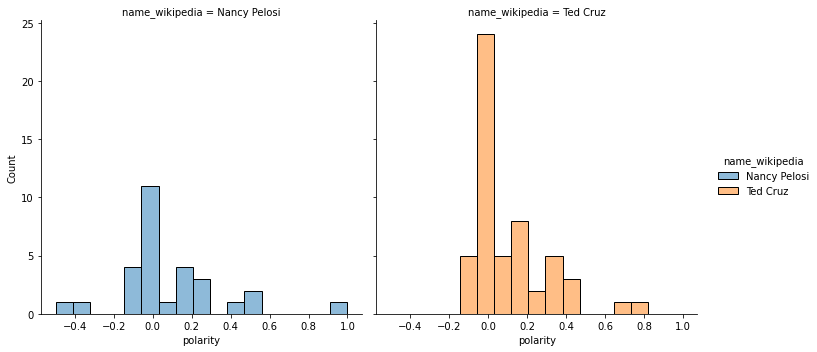

In [130]:
# Subset data to only include rows where the "name" field is "Nancy Pelosi and Ted Cruz"
n_t_congress_tweets = congress_tweets[congress_tweets['name_wikipedia'].isin(['Nancy Pelosi', 'Ted Cruz'])]
sns.displot(n_t_congress_tweets,             # specify data
            x="polarity",   # x-axis feature
            hue = "name_wikipedia",  # color by Name 
            col = "name_wikipedia")  # color by Name 
plt.show()

#sns.scatterplot(data=n_t_congress_tweets, x="polarity", hue="name_wikipedia")
#print(n_t_congress_tweets.head())


## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

In [7]:
...

Ellipsis

### Engineered Text Features

In [8]:
# Engineered Features
...

### Bag-of-words or Tf-idf

In [9]:
# Frequency Based featurization
...

### Word Embedding

In [10]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

#model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

In [11]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

In [12]:
# embedding based featurization
...

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [13]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])
...

### Two Combined Models

In [14]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
...

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**YOUR ANSWER HERE** ...

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**YOUR ANSWER HERE** ...

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**YOUR ANSWER HERE** ...

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**YOUR ANSWER HERE** ...